In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from SALib.sample import saltelli, latin, fast_sampler, morris
from SALib.sample import sobol as ssobol
from SALib.analyze import sobol, fast, rbd_fast, delta, pawn
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
from tqdm import tqdm


In [9]:
# Define the ODE model
def model(y, t, params):
    k1, k2 = params
    dydt = [-k1 * y[0],
            k1 * y[0] - k2 * y[1],
            k2 * y[1]]
    return dydt

In [62]:
# Define parameter ranges
ode_problem = {
    'num_vars': 2,
    'names': ['k1', 'k2'],
    'bounds': [[0.1, 500], [0.1, 500]]
}

In [45]:
def add_data_to_large_df(time_point, small_df, large_df):
    # Initialize a dictionary to store data to be appended
    data = {'time_point': time_point}
    
    # Loop through each row in the small DataFrame and extract the needed values
    for idx in small_df.index:
        data[f'{idx}_delta'] = small_df.loc[idx, 'delta']
        data[f'{idx}_delta_conf'] = small_df.loc[idx, 'delta_conf']
        data[f'{idx}_S1'] = small_df.loc[idx, 'S1']
        data[f'{idx}_S1_conf'] = small_df.loc[idx, 'S1_conf']

    df_row = pd.DataFrame([data])
    # Append the new row to the larger DataFrame
    # large_df = large_df.append(df_row, ignoreIndex=True)
    large_df = pd.concat([large_df, df_row], ignore_index=True)
    return large_df

In [46]:
def generate_csv(problem, sample_size, time_points, parameter, output_name, file_path):

    # Create large dataframe
    df_large = pd.DataFrame(columns=['time_point'])

    # Generate samples
    param_values = ssobol.sample(problem, sample_size)

    # Define initial conditions and time points
    y0 = [10, 0, 0]
    t = np.linspace(0, 10, time_points)

    output = solve_odes(param_values, y0, t)
    
    for i, t_point in tqdm(enumerate(t)):
        if (i == 0):
            continue
    
        Si = delta.analyze(problem, param_values, output[:, i, parameter])
        df_large = add_data_to_large_df(t_point, Si.to_df(), df_large)

    df_large.to_csv((file_path + '/' + output_name + '.csv'), index = False)

In [63]:
def solve_odes(param_values, y0, t):
    # Run the model for each sample
    output = np.empty([param_values.shape[0], t.size, 3])
    for i, params in enumerate(param_values):
        sol = odeint(model, y0, t, args=(params,))
        output[i] = sol

    return output

In [74]:
sample_size = 10000
time_points = 100

param_values = ssobol.sample(ode_problem, sample_size)

y0 = [10, 0, 0]
t = np.linspace(0, 10, time_points)

output = solve_odes(param_values, y0, t)

param_values

/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


array([[425.26946307, 233.18974583],
       [ 44.81204266, 233.18974583],
       [425.26946307, 485.38205755],
       ...,
       [399.66279553, 288.93019814],
       [389.18345974, 368.27720507],
       [389.18345974, 288.93019814]])

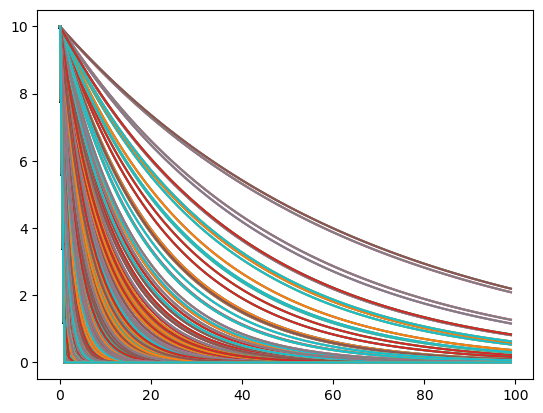

In [70]:
for i in range(sample_size*6):
    plt.plot(output[i, :, 0])


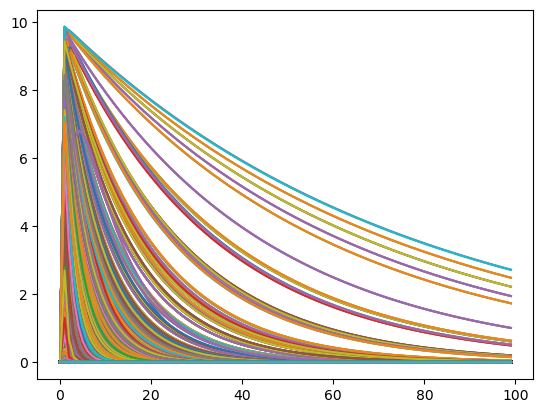

In [71]:
for i in range(sample_size*6):
    plt.plot(output[i, :, 1])

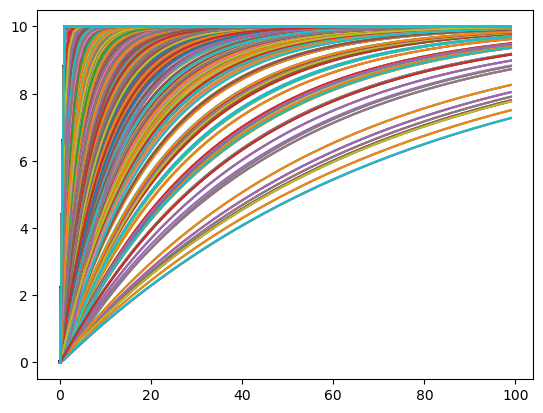

In [73]:
for i in range(sample_size*6):
    plt.plot(output[i, :, 2])

In [13]:
generate_csv(ode_problem, 100, 100, 0, '0', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/500 Bound/N_100')

/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
0it [00:00, ?it/s]/var/folders/zh/dpvqt3794n73s3md_1fs2wmr0000gn/T/ipykernel_66238/2738944218.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  large_df = pd.concat([large_df, df_row], ignore_index=True)
3it [00:02,  1.46it/s]


KeyboardInterrupt: 

In [15]:
generate_csv(ode_problem, 1000, 100, 0, '0', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_1000')
generate_csv(ode_problem, 1000, 100, 1, '1', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_1000')
generate_csv(ode_problem, 1000, 100, 2, '2', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_1000')

/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
0it [00:00, ?it/s]/var/folders/zh/dpvqt3794n73s3md_1fs2wmr0000gn/T/ipykernel_66238/2738944218.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  large_df = pd.concat([large_df, df_row], ignore_index=True)
100it [04:53,  2.93s/it]
/Users/s

In [18]:
generate_csv(ode_problem, 500, 100, 2, '2', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_500')
generate_csv(ode_problem, 100, 100, 0, '0', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_100')
generate_csv(ode_problem, 100, 100, 1, '1', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_100')
generate_csv(ode_problem, 100, 100, 2, '2', '/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/50000 Bound/N_100')

/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/shivanimadhan/anaconda3/envs/kinetics/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
0it [00:00, ?it/s]/var/folders/zh/dpvqt3794n73s3md_1fs2wmr0000gn/T/ipykernel_66238/2738944218.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  large_df = pd.concat([large_df, df_row], ignore_index=True)
100it [02:22,  1.43s/it]
/Users/s

In [31]:
import os
exp_dir = "/Users/shivanimadhan/Documents/research/curve-fit/Experiments/Varying Sample Size/500 Bound"
directories = [os.path.join(exp_dir, name) for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
directories.sort()
    
stored_csvs = []

for dir in directories:
    files = [os.path.join(dir, name) for name in os.listdir(dir) if not os.path.isdir(os.path.join(dir, name))]
    stored_csvs.append(files)

first_column = [row[0] for row in stored_csvs]
second_column = [row[1] for row in stored_csvs]
third_column = [row[2] for row in stored_csvs]

In [32]:
def plot_data(ax, df_large, param_number, data_name, conf_name=None, num_time_points='', color='k'):
    df = df_large

    # Plot the line graph
    ax.plot(df['time_point'], df[data_name], label=data_name, color=color)

    # Shade the confidence interval
    if conf_name is not None:
        ax.fill_between(df['time_point'], df[data_name] - df[conf_name], 
            df[data_name] + df[conf_name], color=color, alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(data_name)
    if conf_name is not None:
        ax.set_title(data_name + ' with Confidence Interval for ' + num_time_points + ' Time Points for Param ' + param_number)
    else:
        ax.set_title(data_name)

    # Add legend
    ax.legend()

    # Show plot
    ax.grid(True)
    # a.show()
    
    return ax

In [33]:
all_dataframes = []

for f in first_column:
    df_large = pd.read_csv(f)
    all_dataframes.append(df_large)

for f in second_column:
    df_large = pd.read_csv(f)
    all_dataframes.append(df_large)

for f in third_column:
    df_large = pd.read_csv(f)
    all_dataframes.append(df_large)

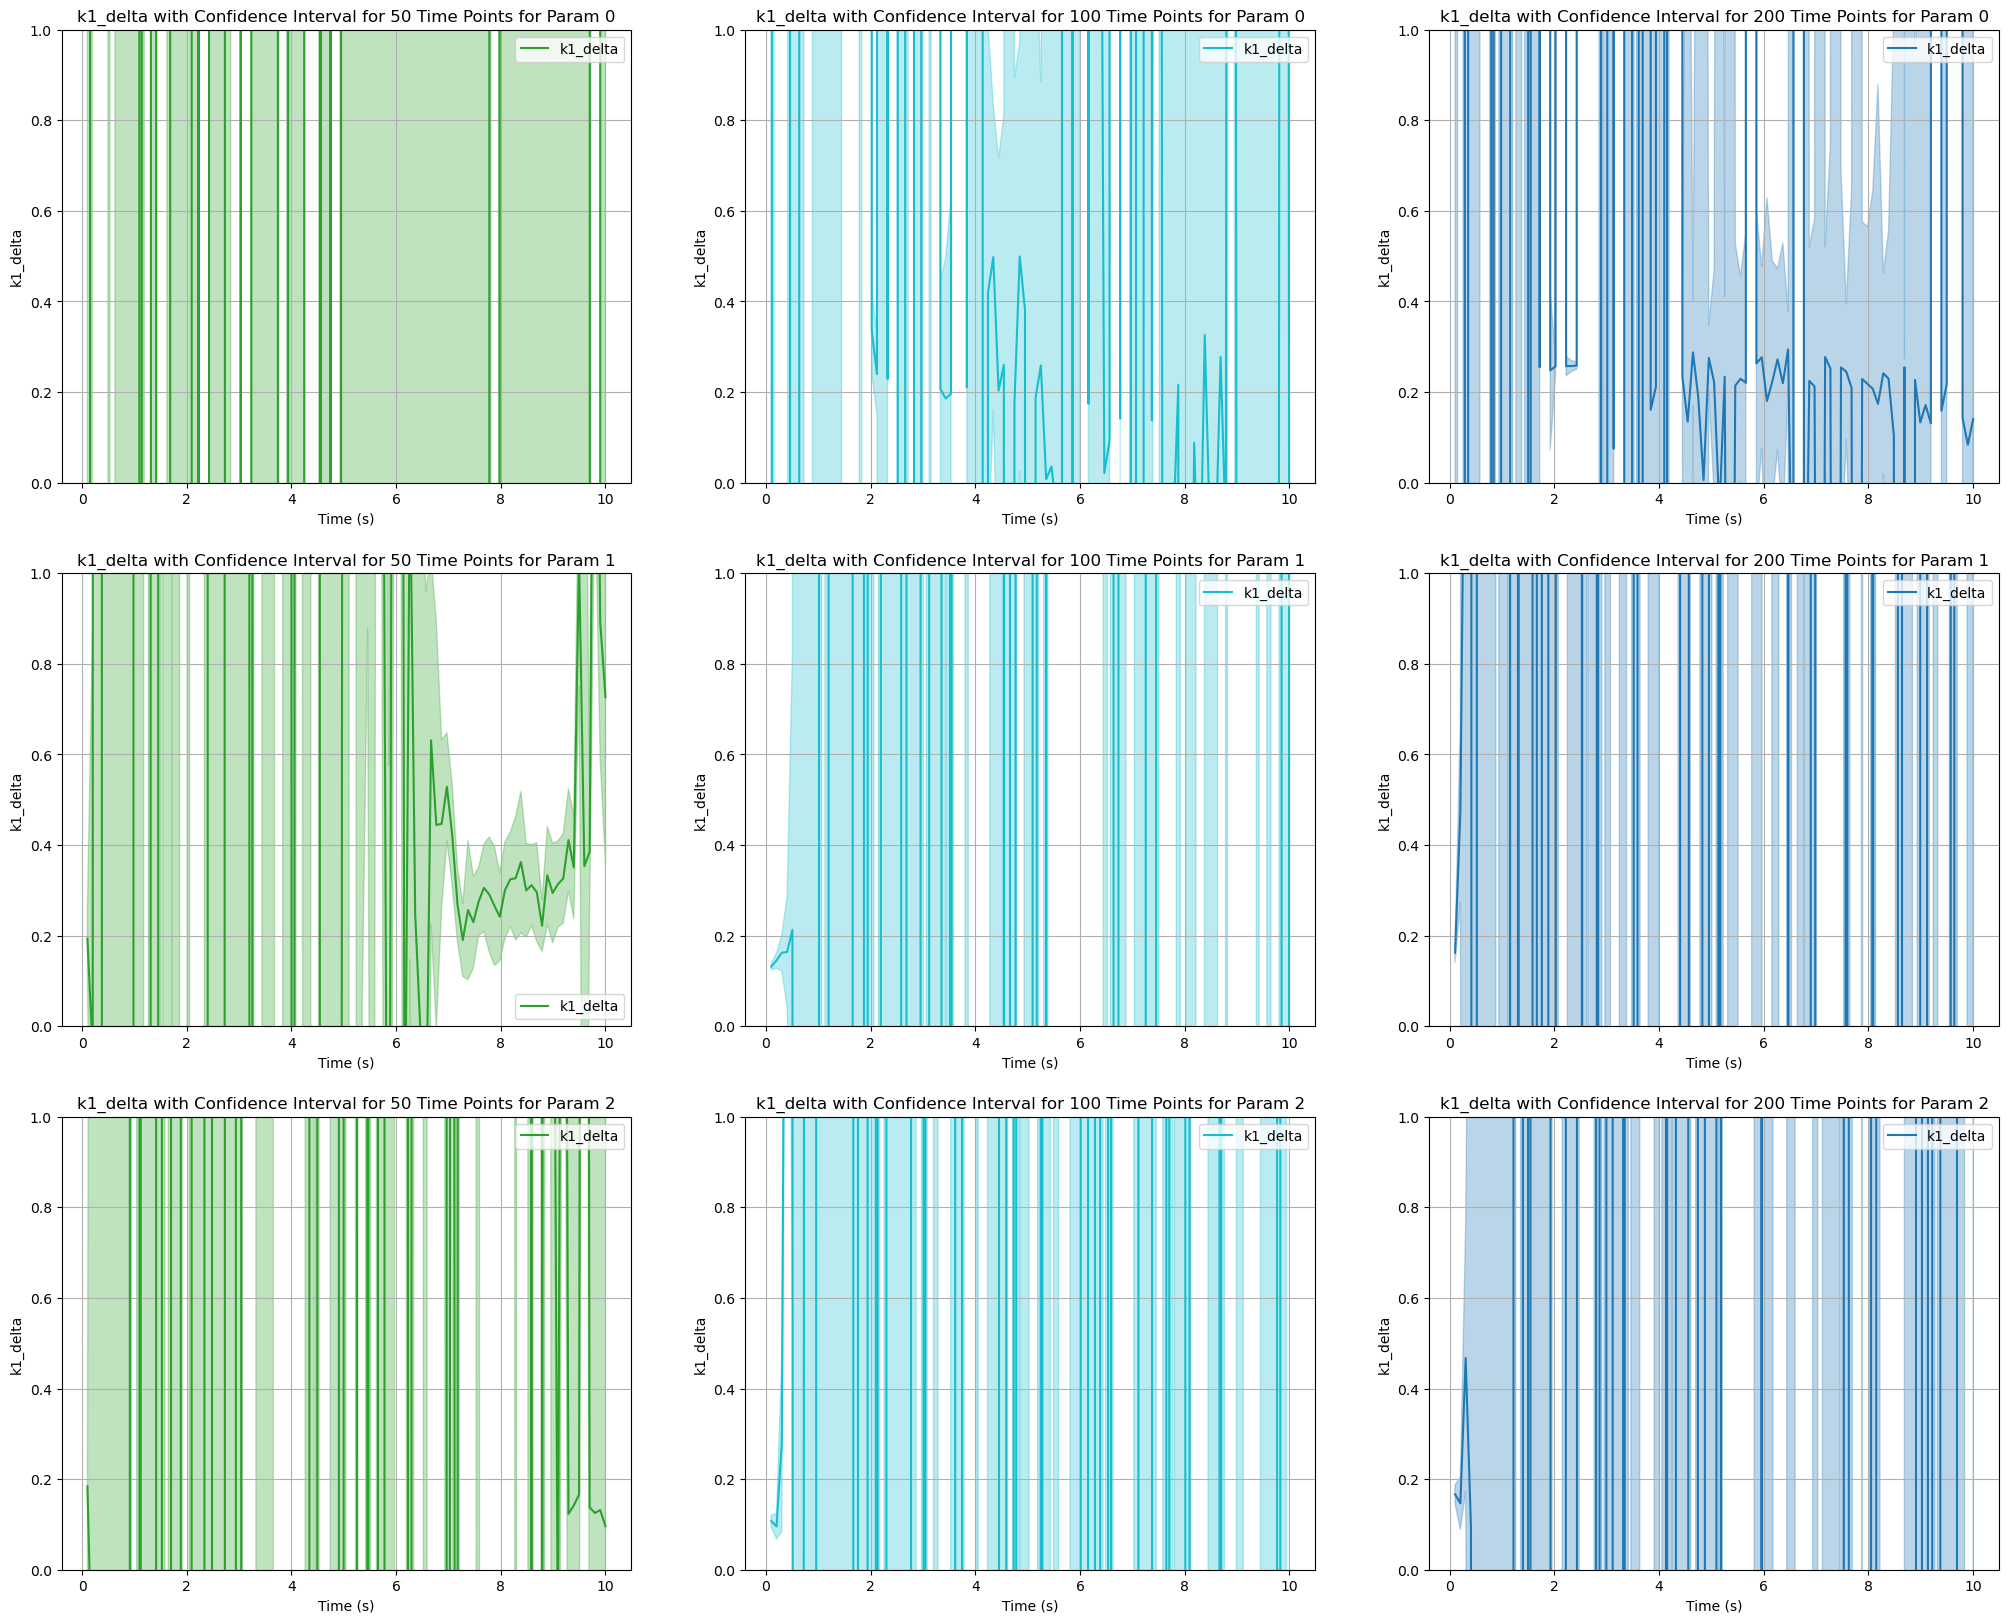

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(25,20), dpi=100)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs.flatten()

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for ax in axs:
    ax.set_ylim([0, 1])

param_number = '0'
data_label = 'k1_delta'
conf_label = 'k1_delta_conf'

ax1 = plot_data(ax1, all_dataframes[0], param_number, data_label, conf_label, '50', 'tab:green')
ax2 = plot_data(ax2, all_dataframes[1], param_number, data_label, conf_label, '100', 'tab:cyan')
ax3 = plot_data(ax3, all_dataframes[2], param_number, data_label, conf_label, '200', 'tab:blue')

param_number = '1'
ax4 = plot_data(ax4, all_dataframes[3], param_number, data_label, conf_label, '50', 'tab:green')
ax5 = plot_data(ax5, all_dataframes[4], param_number, data_label, conf_label, '100', 'tab:cyan')
ax6 = plot_data(ax6, all_dataframes[5], param_number, data_label, conf_label, '200', 'tab:blue')

param_number = '2'
ax7 = plot_data(ax7, all_dataframes[6], param_number, data_label, conf_label, '50', 'tab:green')
ax8 = plot_data(ax8, all_dataframes[7], param_number, data_label, conf_label, '100', 'tab:cyan')
ax9 = plot_data(ax9, all_dataframes[8], param_number, data_label, conf_label, '200', 'tab:blue')

plt.show()